<a href="https://colab.research.google.com/github/istra02/DST-Index-Forecasting-using-ML-Algorithms/blob/main/Forecasting_DST_Index_using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Forecasting DST Index using Machine Learning

# By Emanuel Istratoaie (Student 3rd year FIT, BusEco) 
# and Alina Donea (SoM, DFI) Monash University  

In [ ]:
# Check to determine if GPU is connected
!nvidia-smi




Tue Feb 21 01:40:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Importing libraries needed for the data preprocessing and visualisation
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




In [ ]:
# Import the data csv file and read it 
# Comment out the next 2 lines if running locally
from google.colab import drive
drive.mount('/content/drive')
# Change the csv_path to the path 
csv_path = r'/content/drive/MyDrive/Colab Notebooks/DST(Time-Series Format).csv'
df = pd.read_csv(csv_path)
df




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Datetime,DST Index
0,1975-01-01 00:00:00,-7.0
1,1975-01-01 01:00:00,-9.0
2,1975-01-01 02:00:00,-10.0
3,1975-01-01 03:00:00,-11.0
4,1975-01-01 04:00:00,-12.0
...,...,...
378355,2018-02-28 19:00:00,-5.0
378356,2018-02-28 20:00:00,-2.0
378357,2018-02-28 21:00:00,-1.0
378358,2018-02-28 22:00:00,2.0


In [ ]:
# Convert the time to a datetime object
df.index = pd.to_datetime(df["Datetime"], format = '%Y-%m-%d %H:%M:%S')
df[:10]




,Datetime,DST Index
Datetime,,
1975-01-01 00:00:00,1975-01-01 00:00:00,-7.0
1975-01-01 01:00:00,1975-01-01 01:00:00,-9.0
1975-01-01 02:00:00,1975-01-01 02:00:00,-10.0
1975-01-01 03:00:00,1975-01-01 03:00:00,-11.0
1975-01-01 04:00:00,1975-01-01 04:00:00,-12.0
1975-01-01 05:00:00,1975-01-01 05:00:00,-9.0
1975-01-01 06:00:00,1975-01-01 06:00:00,-8.0
1975-01-01 07:00:00,1975-01-01 07:00:00,-7.0
1975-01-01 08:00:00,1975-01-01 08:00:00,-14.0


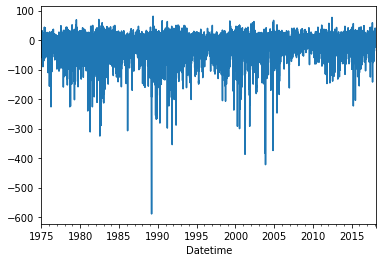

In [ ]:
# Plot the DST Index data
temp = df["DST Index"]
temp.plot()




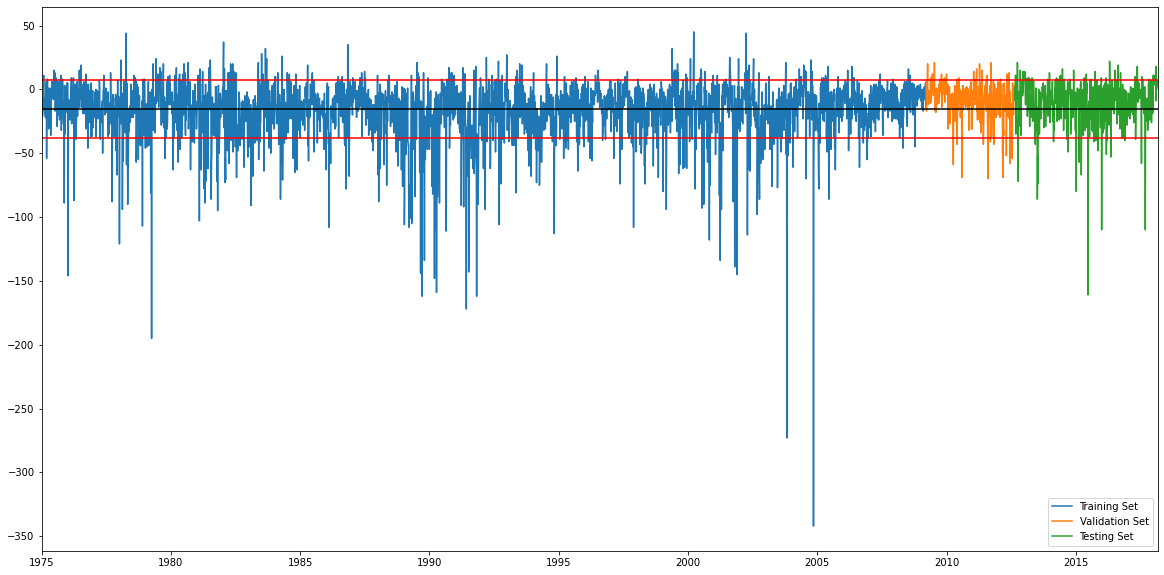

In [ ]:
# Plot a sample of every 100th DST Index, with lines for the mean and standard deviations and all data partitioned into training, validation and testing sets
plt.figure(figsize=(20, 10))
df1 = df[::100]
# print(df1.head())
# print(df.iloc[-1, :])
train, val, test = 3000, 3300, 3783
ax = plt.gca()
ax.plot(df1["DST Index"][:train], label = "Training Set")
ax.plot(df1["DST Index"][train-1:val], label = "Validation Set")
ax.plot(df1["DST Index"][val-1:test], label = "Testing Set")
ax.axhline(y = -15.5015, color = 'k', linestyle = '-')
ax.axhline(y = -15.5015+22.89183, color = 'r', linestyle = '-')
ax.axhline(y = -15.5015-22.89183, color = 'r', linestyle = '-')
ax.legend(loc="lower right")
start, end = pd.to_datetime("1975-01-01 00:00:00"), pd.to_datetime("2018-02-28 23:00:00")
ax.set_xlim(start, end)
plt.show()




In [ ]:
#Function for preprocessing the data by convertng the dataframe to numpy arrays
def df_to_xy(df, BATCH_SIZE = 5):
  df_as_np =  df.to_numpy()
  x = []
  y = []
  for i in range(len(df_as_np)-BATCH_SIZE):
    row = [[a] for a in df_as_np[i:i+BATCH_SIZE]]
    x.append(row)
    label = df_as_np[i+BATCH_SIZE]
    y.append(label)
  return np.array(x), np.array(y)




In [ ]:
#Setting the batch size to 5 and creating numpy arrays containing the data before outputing the shape of the arrays
BATCH_SIZE = 5
x,y = df_to_xy(temp, BATCH_SIZE)
x.shape, y.shape




((378355, 5, 1), (378355,))

In [ ]:
# Partitioning the data into training, validation and testing arrays before outputing their shape
x_train, y_train = x[:300000], y[:300000]
x_val, y_val = x[300000:330000], y[300000:330000]
x_test, y_test = x[330000:], y[330000:]
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape




((300000, 5, 1), (300000,), (30000, 5, 1), (30000,), (48355, 5, 1), (48355,))

In [ ]:
# Importing the libraries needed for the implementation and training of the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model




In [ ]:
#Define the single LSTM model
model1 = Sequential()
model1.add(InputLayer((BATCH_SIZE,1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Define the model checkpoint
cp1 = ModelCheckpoint('model1/', save_best_only=True)

# Compile the model with the Adam optimizer and the Mean Squared Error loss function
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])




In [ ]:
# Train the model with the model checkpoint callbacks
history = model1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, callbacks=[cp1])




Epoch 1/10
9371/9375 [============================>.] - ETA: 0s - loss: 177.3007 - root_mean_squared_error: 13.3154

9375/9375 [==============================] - 52s 5ms/step - loss: 177.2453 - root_mean_squared_error: 13.3134 - val_loss: 10.2284 - val_root_mean_squared_error: 3.1982
Epoch 2/10
9366/9375 [============================>.] - ETA: 0s - loss: 37.1448 - root_mean_squared_error: 6.0947

9375/9375 [==============================] - 43s 5ms/step - loss: 37.1289 - root_mean_squared_error: 6.0933 - val_loss: 9.9450 - val_root_mean_squared_error: 3.1536
Epoch 3/10
9375/9375 [==============================] - 40s 4ms/step - loss: 27.7032 - root_mean_squared_error: 5.2634 - val_loss: 10.0315 - val_root_mean_squared_error: 3.1673
Epoch 4/10
9375/9375 [==============================] - ETA: 0s - loss: 24.8723 - root_mean_squared_error: 4.9872

9375/9375 [==============================] - 43s 5ms/step - loss: 24.8723 - root_mean_squared_error: 4.9872 - val_loss: 9.8793 - val_root_mean_squared_error: 3.1431
Epoch 5/10
9375/9375 [==============================] - 39s 4ms/step - loss: 23.6417 - root_mean_squared_error: 4.8623 - val_loss: 9.9000 - val_root_mean_squared_error: 3.1464
Epoch 6/10
9372/9375 [============================>.] - ETA: 0s - loss: 22.9590 - root_mean_squared_error: 4.7916

9375/9375 [==============================] - 45s 5ms/step - loss: 22.9563 - root_mean_squared_error: 4.7913 - val_loss: 9.7802 - val_root_mean_squared_error: 3.1273
Epoch 7/10
9375/9375 [==============================] - 39s 4ms/step - loss: 22.5829 - root_mean_squared_error: 4.7522 - val_loss: 9.7829 - val_root_mean_squared_error: 3.1278
Epoch 8/10
9375/9375 [==============================] - 40s 4ms/step - loss: 22.3897 - root_mean_squared_error: 4.7318 - val_loss: 9.9326 - val_root_mean_squared_error: 3.1516
Epoch 9/10
9375/9375 [==============================] - 40s 4ms/step - loss: 22.1580 - root_mean_squared_error: 4.7072 - val_loss: 10.2998 - val_root_mean_squared_error: 3.2093
Epoch 10/10
9375/9375 [==============================] - 40s 4ms/step - loss: 21.9442 - root_mean_squared_error: 4.6845 - val_loss: 9.8774 - val_root_mean_squared_error: 3.1428


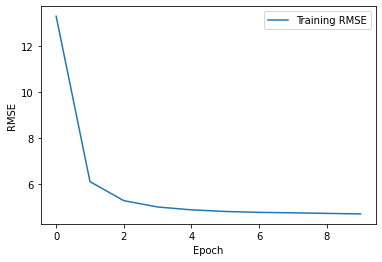

In [ ]:
# Record the RMSE at each epoch
train_rmse = history.history['root_mean_squared_error']

# Plot the RMSE values
plt.plot(train_rmse, label='Training RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()




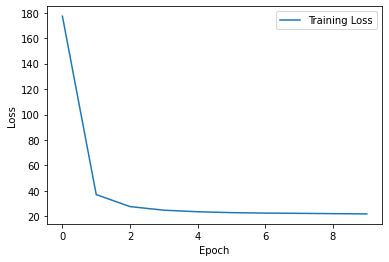

In [ ]:
# Record the Loss at each epoch
train_rmse = history.history['loss']

# Plot the Loss values
plt.plot(train_rmse, label='Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Load the best model into mod1
mod1 = load_model('model1/')




1512/1512 [==============================] - 4s 2ms/step


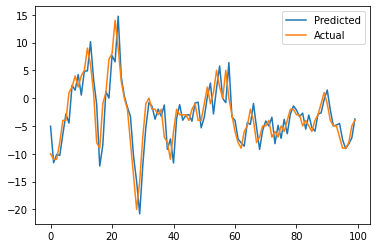

In [ ]:
# Add the predictions to a dataframe
test_predictions = mod1.predict(x_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})

# Plot the predictions for the first 100 datapoints of the testing set
plt.plot(test_results['Test Predictions'][:100], label = "Predicted")
plt.plot(test_results['Actuals'][:100], label = "Actual")
plt.legend(loc="upper right")




In [ ]:
# Define the double LSTM model
model2 = Sequential()
model2.add(LSTM(50, return_sequences=True, input_shape=(BATCH_SIZE,1)))
model2.add(LSTM(50, return_sequences=False))
model2.add(Dense(25))
model2.add(Dense(1))

model2.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 5, 50)             10400     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Define the model checkpoint
cp2 = ModelCheckpoint('model2/', save_best_only= True)

# Compile the model with the Adam optimizer and the Mean Squared Error loss function
model2.compile(loss = MeanSquaredError(), optimizer= Adam(learning_rate=0.0001), metrics = [RootMeanSquaredError()])




In [ ]:
# Train the model with the model checkpoint callbacks
model2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs = 10, callbacks = [cp2])




Epoch 1/10
9368/9375 [============================>.] - ETA: 0s - loss: 95.6727 - root_mean_squared_error: 9.7812

9375/9375 [==============================] - 70s 7ms/step - loss: 95.6166 - root_mean_squared_error: 9.7784 - val_loss: 9.9203 - val_root_mean_squared_error: 3.1496
Epoch 2/10
9371/9375 [============================>.] - ETA: 0s - loss: 25.6598 - root_mean_squared_error: 5.0655

9375/9375 [==============================] - 65s 7ms/step - loss: 25.6555 - root_mean_squared_error: 5.0651 - val_loss: 9.8434 - val_root_mean_squared_error: 3.1374
Epoch 3/10
9375/9375 [==============================] - 58s 6ms/step - loss: 22.9616 - root_mean_squared_error: 4.7918 - val_loss: 9.8526 - val_root_mean_squared_error: 3.1389
Epoch 4/10
9375/9375 [==============================] - 58s 6ms/step - loss: 22.2796 - root_mean_squared_error: 4.7201 - val_loss: 10.2613 - val_root_mean_squared_error: 3.2033
Epoch 5/10
9375/9375 [==============================] - 59s 6ms/step - loss: 21.9396 - root_mean_squared_error: 4.6840 - val_loss: 10.2360 - val_root_mean_squared_error: 3.1994
Epoch 6/10
9375/9375 [==============================] - 58s 6ms/step - loss: 21.7211 - root_mean_squared_error: 4.6606 - val_loss: 10.3453 - val_root_mean_squared_error: 3.2164
Epoch 7/10
9371/9375 [============================>.] - ETA: 0s - loss: 21.6073 - root_mean_squared_error: 4.6484

9375/9375 [==============================] - 67s 7ms/step - loss: 21.6058 - root_mean_squared_error: 4.6482 - val_loss: 9.7458 - val_root_mean_squared_error: 3.1218
Epoch 8/10
9375/9375 [==============================] - 58s 6ms/step - loss: 21.5043 - root_mean_squared_error: 4.6373 - val_loss: 9.9877 - val_root_mean_squared_error: 3.1603
Epoch 9/10
9375/9375 [==============================] - 58s 6ms/step - loss: 21.3900 - root_mean_squared_error: 4.6249 - val_loss: 10.0349 - val_root_mean_squared_error: 3.1678
Epoch 10/10
9369/9375 [============================>.] - ETA: 0s - loss: 21.3806 - root_mean_squared_error: 4.6239

9375/9375 [==============================] - 67s 7ms/step - loss: 21.3778 - root_mean_squared_error: 4.6236 - val_loss: 9.7374 - val_root_mean_squared_error: 3.1205


In [ ]:
# Load the best model into mod2
mod2 = load_model('model2/')




1512/1512 [==============================] - 5s 3ms/step


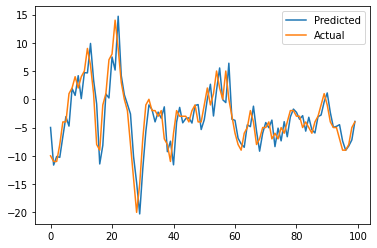

In [ ]:
# Add the predictions to a dataframe
test_predictions = mod2.predict(x_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})

# Plot the predictions for the first 100 datapoints of the testing set
plt.plot(test_results['Test Predictions'][:100], label = "Predicted")
plt.plot(test_results['Actuals'][:100], label = "Actual")
plt.legend(loc="upper right")




In [ ]:
# Define the 1D CNN model
model3 = Sequential()
model3.add(InputLayer((BATCH_SIZE,1)))
model3.add(Conv1D(64, kernel_size = 2))
model3.add(Flatten())
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))

model3.summary()




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             192       
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 8)                 2056      
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Define the model checkpoint
cp3 = ModelCheckpoint('model3/', save_best_only= True)

# Compile the model with the Adam optimizer and the Mean Squared Error loss function
model3.compile(loss = MeanSquaredError(), optimizer= Adam(learning_rate=0.0001), metrics = [RootMeanSquaredError()])




In [ ]:
# Train the model with the model checkpoint callbacks
model3.fit(x_train, y_train, validation_data=(x_val, y_val), epochs = 10, callbacks = [cp3])




Epoch 1/10
9361/9375 [============================>.] - ETA: 0s - loss: 39.9862 - root_mean_squared_error: 6.3235

9375/9375 [==============================] - 39s 4ms/step - loss: 39.9523 - root_mean_squared_error: 6.3208 - val_loss: 10.1871 - val_root_mean_squared_error: 3.1917
Epoch 2/10
9375/9375 [==============================] - ETA: 0s - loss: 21.6119 - root_mean_squared_error: 4.6489

9375/9375 [==============================] - 32s 3ms/step - loss: 21.6119 - root_mean_squared_error: 4.6489 - val_loss: 10.1318 - val_root_mean_squared_error: 3.1831
Epoch 3/10
9364/9375 [============================>.] - ETA: 0s - loss: 21.4951 - root_mean_squared_error: 4.6363

9375/9375 [==============================] - 33s 4ms/step - loss: 21.4921 - root_mean_squared_error: 4.6360 - val_loss: 9.9936 - val_root_mean_squared_error: 3.1613
Epoch 4/10
9375/9375 [==============================] - 34s 4ms/step - loss: 21.4321 - root_mean_squared_error: 4.6295 - val_loss: 10.7983 - val_root_mean_squared_error: 3.2861
Epoch 5/10
9364/9375 [============================>.] - ETA: 0s - loss: 21.3771 - root_mean_squared_error: 4.6235

9375/9375 [==============================] - 32s 3ms/step - loss: 21.3757 - root_mean_squared_error: 4.6234 - val_loss: 9.9263 - val_root_mean_squared_error: 3.1506
Epoch 6/10
9375/9375 [==============================] - 32s 3ms/step - loss: 21.3601 - root_mean_squared_error: 4.6217 - val_loss: 9.9455 - val_root_mean_squared_error: 3.1536
Epoch 7/10
9359/9375 [============================>.] - ETA: 0s - loss: 21.2836 - root_mean_squared_error: 4.6134

9375/9375 [==============================] - 32s 3ms/step - loss: 21.3307 - root_mean_squared_error: 4.6185 - val_loss: 9.8733 - val_root_mean_squared_error: 3.1422
Epoch 8/10
9375/9375 [==============================] - 32s 3ms/step - loss: 21.2822 - root_mean_squared_error: 4.6133 - val_loss: 9.8987 - val_root_mean_squared_error: 3.1462
Epoch 9/10
9360/9375 [============================>.] - ETA: 0s - loss: 21.2257 - root_mean_squared_error: 4.6071

9375/9375 [==============================] - 34s 4ms/step - loss: 21.2195 - root_mean_squared_error: 4.6065 - val_loss: 9.8670 - val_root_mean_squared_error: 3.1412
Epoch 10/10
9361/9375 [============================>.] - ETA: 0s - loss: 21.2082 - root_mean_squared_error: 4.6052

9375/9375 [==============================] - 33s 4ms/step - loss: 21.2073 - root_mean_squared_error: 4.6051 - val_loss: 9.8627 - val_root_mean_squared_error: 3.1405


In [ ]:
# Load the best model into mod3
mod3 = load_model('model3/')




1512/1512 [==============================] - 3s 2ms/step


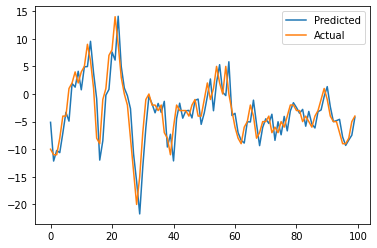

In [ ]:
# Add the predictions to a dataframe
test_predictions = mod3.predict(x_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})

# Plot the predictions for the first 100 datapoints of the testing set
plt.plot(test_results['Test Predictions'][:100], label = "Predicted")
plt.plot(test_results['Actuals'][:100], label = "Actual")
plt.legend(loc="upper right")




In [ ]:
# Define the GRU model
model4 = Sequential()
model4.add(InputLayer((BATCH_SIZE,1)))
model4.add(GRU(64))
model4.add(Flatten())
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()




Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Define the model checkpoint
cp4 = ModelCheckpoint('model4/', save_best_only= True)

# Compile the model with the Adam optimizer and the Mean Squared Error loss function
model4.compile(loss = MeanSquaredError(), optimizer= Adam(learning_rate=0.0001), metrics = [RootMeanSquaredError()])




In [ ]:
# Train the model with the model checkpoint callbacks
model4.fit(x_train, y_train, validation_data=(x_val, y_val), epochs = 10, callbacks = [cp4])




Epoch 1/10
9368/9375 [============================>.] - ETA: 0s - loss: 157.4954 - root_mean_squared_error: 12.5497

9375/9375 [==============================] - 46s 5ms/step - loss: 157.3864 - root_mean_squared_error: 12.5454 - val_loss: 10.0122 - val_root_mean_squared_error: 3.1642
Epoch 2/10
9368/9375 [============================>.] - ETA: 0s - loss: 36.1248 - root_mean_squared_error: 6.0104

9375/9375 [==============================] - 43s 5ms/step - loss: 36.1090 - root_mean_squared_error: 6.0091 - val_loss: 9.8190 - val_root_mean_squared_error: 3.1335
Epoch 3/10
9375/9375 [==============================] - 38s 4ms/step - loss: 27.5085 - root_mean_squared_error: 5.2449 - val_loss: 9.9804 - val_root_mean_squared_error: 3.1592
Epoch 4/10
9375/9375 [==============================] - 39s 4ms/step - loss: 24.7189 - root_mean_squared_error: 4.9718 - val_loss: 9.8598 - val_root_mean_squared_error: 3.1400
Epoch 5/10
9369/9375 [============================>.] - ETA: 0s - loss: 23.4448 - root_mean_squared_error: 4.8420

9375/9375 [==============================] - 43s 5ms/step - loss: 23.4453 - root_mean_squared_error: 4.8420 - val_loss: 9.7475 - val_root_mean_squared_error: 3.1221
Epoch 6/10
9375/9375 [==============================] - 40s 4ms/step - loss: 22.7942 - root_mean_squared_error: 4.7743 - val_loss: 9.7805 - val_root_mean_squared_error: 3.1274
Epoch 7/10
9375/9375 [==============================] - 40s 4ms/step - loss: 22.3731 - root_mean_squared_error: 4.7300 - val_loss: 9.8842 - val_root_mean_squared_error: 3.1439
Epoch 8/10
9375/9375 [==============================] - 40s 4ms/step - loss: 22.1060 - root_mean_squared_error: 4.7017 - val_loss: 10.0135 - val_root_mean_squared_error: 3.1644
Epoch 9/10
9375/9375 [==============================] - 39s 4ms/step - loss: 21.9369 - root_mean_squared_error: 4.6837 - val_loss: 9.8486 - val_root_mean_squared_error: 3.1383
Epoch 10/10
9375/9375 [==============================] - 40s 4ms/step - loss: 21.7705 - root_mean_squared_error: 4.6659 - val_loss

In [ ]:
# Load the best model into mod4
mod4 = load_model('model1/')




1512/1512 [==============================] - 4s 2ms/step


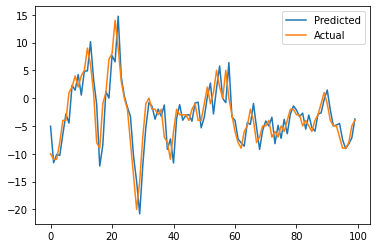

In [ ]:
# Add the predictions to a dataframe
test_predictions = mod4.predict(x_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})

# Plot the predictions for the first 100 datapoints of the testing set
plt.plot(test_results['Test Predictions'][:100], label = "Predicted")
plt.plot(test_results['Actuals'][:100], label = "Actual")
plt.legend(loc="upper right")




In [ ]:
# Use all models to forecast testing data
test_predictions1 = model1.predict(x_test).flatten()
test_predictions2 = model2.predict(x_test).flatten()
test_predictions3 = model3.predict(x_test).flatten()
test_predictions4 = model4.predict(x_test).flatten()
test_results = pd.DataFrame(data={'Single LSTM Predictions':test_predictions1, 'Double LSTM Predictions':test_predictions2, '1-D CNN Predictions':test_predictions3, 'GRU Predictions':test_predictions4, 'Actuals':y_test})




1512/1512 [==============================] - 3s 2ms/step


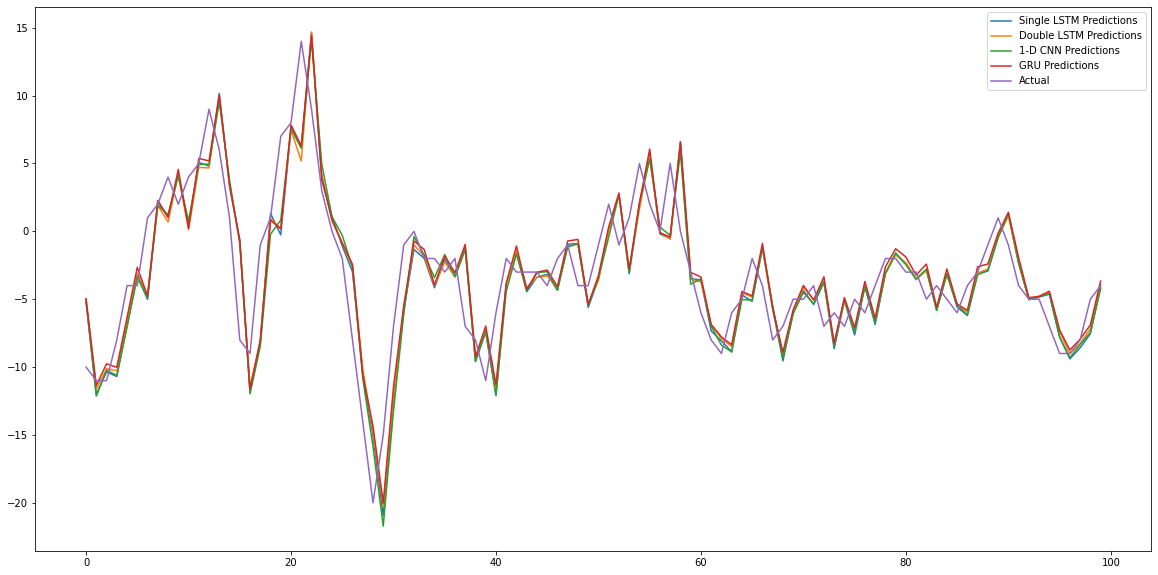

In [ ]:
# Plot the predictions of each model on the first dp (100) data points of the testing data
plt.figure(figsize=(20,10))
dp = 100
plt.plot(test_results['Single LSTM Predictions'][:dp], label = "Single LSTM Predictions")
plt.plot(test_results['Double LSTM Predictions'][:dp], label = "Double LSTM Predictions")
plt.plot(test_results['1-D CNN Predictions'][:dp], label = "1-D CNN Predictions")
plt.plot(test_results['GRU Predictions'][:dp], label = "GRU Predictions")
plt.plot(test_results['Actuals'][:dp], label = "Actual")
plt.legend(loc="upper right")




In [ ]:
# The following cells of code are intended to be run independently for testing various model configurations conveniently
# Please note that "Model Implementation" and "Model Training" cells need to be run consecutively each time a hyperparameter is adjusted to avoid training the same model




In [ ]:
# Data Preparation:

# Import statements
import tensorflow as tf
import os
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from google.colab import drive

# Read the data file
# Comment out the next 2 lines if running locally
from google.colab import drive
drive.mount('/content/drive')
# Change the csv_path to the path 
csv_path = r'/content/drive/MyDrive/Colab Notebooks/DST(Time-Series Format).csv'
df = pd.read_csv(csv_path)

# Convert time series to Datetime object
df.index = pd.to_datetime(df["Datetime"], format = '%Y-%m-%d %H:%M:%S')
df = df['DST Index']

# Define a function that preprocesses the data
def df_to_xy(df, BATCH_SIZE = 5):
  df_as_np =  df.to_numpy()
  x = []
  y = []
  for i in range(len(df_as_np)-BATCH_SIZE):
    row = [[a] for a in df_as_np[i:i+BATCH_SIZE]]
    x.append(row)
    label = df_as_np[i+BATCH_SIZE]
    y.append(label)
  return np.array(x), np.array(y)




In [ ]:
# Model Creation:

#Setting the batch size to 5 and creating numpy arrays containing the data
BATCH_SIZE = 5
x,y = df_to_xy(df, BATCH_SIZE)

# Partitioning the data into training, validation and testing arrays before outputing their shape
x_train, y_train = x[:300000], y[:300000]
x_val, y_val = x[300000:330000], y[300000:330000]
x_test, y_test = x[330000:], y[330000:]

# Creating the model
model1 = Sequential()
# Uncomment a block of the following code to test a model


# model1.add(InputLayer((BATCH_SIZE,1)))
# model1.add(LSTM(64))
# model1.add(Dense(8, 'relu'))
# model1.add(Dense(1, 'linear'))


# model1.add(LSTM(50, return_sequences=True, input_shape=(BATCH_SIZE,1)))
# model1.add(LSTM(50, return_sequences=False))
# model1.add(Dense(25))
# model1.add(Dense(1))


# model1.add(InputLayer((BATCH_SIZE,1)))
# model1.add(Conv1D(64, kernel_size = 2))
# model1.add(Flatten())
# model1.add(Dense(8, 'relu'))
# model1.add(Dense(1, 'linear'))


# model1.add(InputLayer((BATCH_SIZE,1)))
# model1.add(GRU(64))
# model1.add(Flatten())
# model1.add(Dense(8, 'relu'))
# model1.add(Dense(1, 'linear'))


# model1.add(InputLayer((BATCH_SIZE,1)))
# model1.add(Conv1D(64, kernel_size = 2))
# model1.add(Conv1D(64, kernel_size = 2))
# model1.add(Conv1D(64, kernel_size = 2))
# model1.add(Flatten())
# model1.add(Dense(8, 'relu'))
# model1.add(Dense(1, 'linear'))


model1.summary()




Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 4, 64)             192       
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 64)             8256      
                                                                 
 conv1d_3 (Conv1D)           (None, 2, 64)             8256      
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 8)                 1032      
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,745
Trainable params: 17,745
Non-trai

In [ ]:
# Model Training:

# Define the model checkpoint
cp = ModelCheckpoint('model1/', save_best_only= True)

# Compile the model with the Adam optimizer and the Mean Squared Error loss function
model1.compile(loss = MeanSquaredError(), optimizer= Adam(learning_rate=0.0001), metrics = [RootMeanSquaredError()])

# Train the model with the model checkpoint callbacks
model1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs = 10, callbacks = [cp])




Epoch 1/10
9364/9375 [============================>.] - ETA: 0s - loss: 22.0940 - root_mean_squared_error: 4.7004

9375/9375 [==============================] - 44s 5ms/step - loss: 22.0888 - root_mean_squared_error: 4.6999 - val_loss: 9.9837 - val_root_mean_squared_error: 3.1597
Epoch 2/10
9375/9375 [==============================] - 42s 4ms/step - loss: 21.8351 - root_mean_squared_error: 4.6728 - val_loss: 10.0590 - val_root_mean_squared_error: 3.1716
Epoch 3/10
9370/9375 [============================>.] - ETA: 0s - loss: 21.7829 - root_mean_squared_error: 4.6672

9375/9375 [==============================] - 42s 4ms/step - loss: 21.7915 - root_mean_squared_error: 4.6681 - val_loss: 9.8433 - val_root_mean_squared_error: 3.1374
Epoch 4/10
9375/9375 [==============================] - 41s 4ms/step - loss: 21.6042 - root_mean_squared_error: 4.6480 - val_loss: 9.9153 - val_root_mean_squared_error: 3.1489
Epoch 5/10
9375/9375 [==============================] - 41s 4ms/step - loss: 21.5129 - root_mean_squared_error: 4.6382 - val_loss: 10.0833 - val_root_mean_squared_error: 3.1754
Epoch 6/10
9375/9375 [==============================] - 41s 4ms/step - loss: 21.5166 - root_mean_squared_error: 4.6386 - val_loss: 9.8694 - val_root_mean_squared_error: 3.1416
Epoch 7/10
9375/9375 [==============================] - 41s 4ms/step - loss: 21.4139 - root_mean_squared_error: 4.6275 - val_loss: 10.1295 - val_root_mean_squared_error: 3.1827
Epoch 8/10
9375/9375 [==============================] - 41s 4ms/step - loss: 21.4190 - root_mean_squared_error: 4.6281 - val_loss

9375/9375 [==============================] - 42s 4ms/step - loss: 21.3601 - root_mean_squared_error: 4.6217 - val_loss: 9.8200 - val_root_mean_squared_error: 3.1337
Epoch 10/10
9366/9375 [============================>.] - ETA: 0s - loss: 21.3513 - root_mean_squared_error: 4.6207

9375/9375 [==============================] - 41s 4ms/step - loss: 21.3629 - root_mean_squared_error: 4.6220 - val_loss: 9.7581 - val_root_mean_squared_error: 3.1238


In [ ]:
# Load the best model into mod1
mod1 = load_model('model1/')




1512/1512 [==============================] - 3s 2ms/step


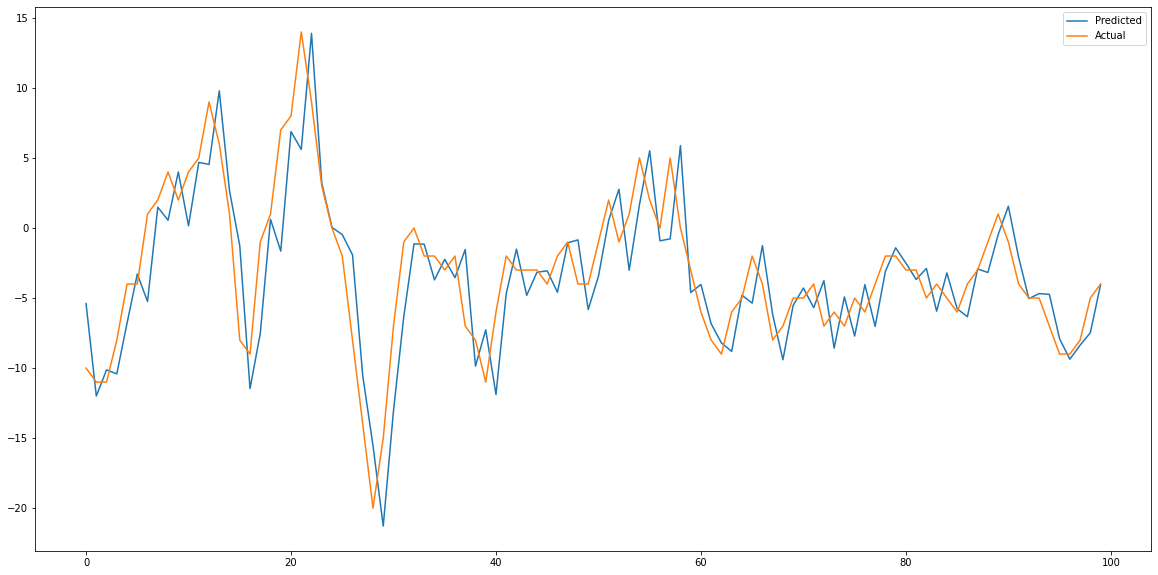

In [ ]:
# Add the predictions to a dataframe
test_predictions = mod1.predict(x_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})

# Plot the predictions for the first 100 datapoints of the testing set
plt.figure(figsize=(20,10))
plt.plot(test_results['Test Predictions'][:100], label = "Predicted")
plt.plot(test_results['Actuals'][:100], label = "Actual")
plt.legend(loc="upper right")


